In [146]:
import numpy as np
import yaml
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from matplotlib import patches
import matplotlib.pyplot as plt

from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

@dataclass
class Geometry():

    vv_major_radius: float = 0.3048
    vv_minor_radius_to_inside: float = 0.1619
    vv_minor_radius_to_outside: float = 0.185
    cs_height: float = 0.7
    cs_inner_radius: float = 0.08
    cs_outer_radius: float = 0.115
    tf_dee_inner_radius: float = 0.075
    tf_dee_outer_radius: float = 0.6
    tf_thickness: float = 0.07
    contour_points: int = 100

    def __post_init__(self):
        self.geom = {'coils': {}}
        self.coil_patches = []

        self._create_vv()
        self._create_tf()
        self.create_coil('cs', (self.cs_inner_radius + self.cs_outer_radius)/2, 0, self.cs_outer_radius - self.cs_inner_radius, self.cs_height)

    def _create_vv(self):
        vv_inner_wall = self._circle_contour(self.vv_major_radius, 0, self.vv_minor_radius_to_inside)
        vv_outer_wall = self._circle_contour(self.vv_major_radius, 0, self.vv_minor_radius_to_outside)
        self.geom['vv'] = [vv_inner_wall.tolist(), vv_outer_wall.tolist()]

        self.vv_patch = patches.Annulus((self.vv_major_radius, 0), self.vv_minor_radius_to_outside,
            self.vv_minor_radius_to_outside-self.vv_minor_radius_to_inside, color='gray')

    def _circle_contour(self, r0, z0, R):
        theta = np.linspace(0, 2*np.pi, self.contour_points)
        contour = np.stack([r0 + R * np.cos(theta), z0 + R * np.sin(theta)], axis=1)
        return contour

    def _create_tf(self):
        k = 1/2 * np.log(self.tf_dee_outer_radius/self.tf_dee_inner_radius)

        func = lambda t, y: np.array([-y[1], (1+y[1]**2)**(3/2)/(k * t)])
        t_eval = np.linspace(self.tf_dee_outer_radius, self.tf_dee_inner_radius, self.contour_points)
        sol = solve_ivp(func, [self.tf_dee_outer_radius, self.tf_dee_inner_radius], [0, 1e5], t_eval=t_eval)

        r = np.concatenate([sol.t[:1:-1], sol.t])
        z = np.concatenate([sol.y[0][:1:-1], -sol.y[0]])

        self.tf_patch = patches.Polygon(np.stack([r, z], axis=-1), closed=True, fill=False, color='purple')

    def create_coil(self, name, r0, z0, w, h):
        self.geom['coils'][name] = {'r0': r0, 'z0': z0, 'w': w, 'h': h}
        self.coil_patches.append(patches.Rectangle((r0 - w/2, z0 - h/2), w, h))

    def save(self, filename):
        with open(f'meshes/{filename}.yaml', 'w') as file:
            yaml.dump(self.geom, file)

    def plot(self):
        ax = plt.subplot()

        ax.add_patch(self.vv_patch)
        ax.add_patch(self.tf_patch)
        for coil_patch in self.coil_patches:
            ax.add_patch(coil_patch)
        
        ax.set_xlim(0, 0.8)
        ax.set_ylim(-0.7, 0.7)
        ax.set_aspect('equal')
        plt.show()

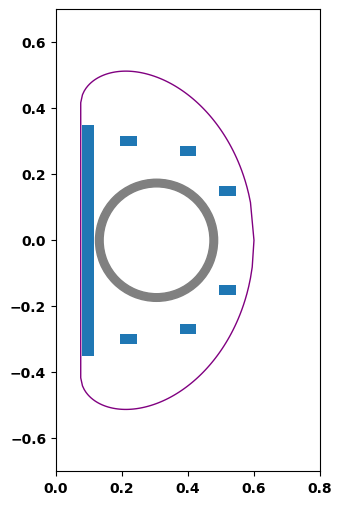

In [163]:
# Create geometry with custom PF coils

geom_name = 'ATOMCRAFT_geom1'

g = Geometry()
g.create_coil('PF1U', 0.22, 0.3, 0.05, 0.03)
g.create_coil('PF1D', 0.22, -0.3, 0.05, 0.03)
g.create_coil('PF2U', 0.4, 0.27, 0.05, 0.03)
g.create_coil('PF2D', 0.4, -0.27, 0.05, 0.03)
g.create_coil('PF3U', 0.52, 0.15, 0.05, 0.03)
g.create_coil('PF3D', 0.52, -0.15, 0.05, 0.03)
g.save(geom_name)

g.plot()

Assembling regions:
  # of unique points    = 701
  # of unique segments  = 34
Generating mesh:
  # of points  = 7733
  # of cells   = 15316
  # of regions = 10


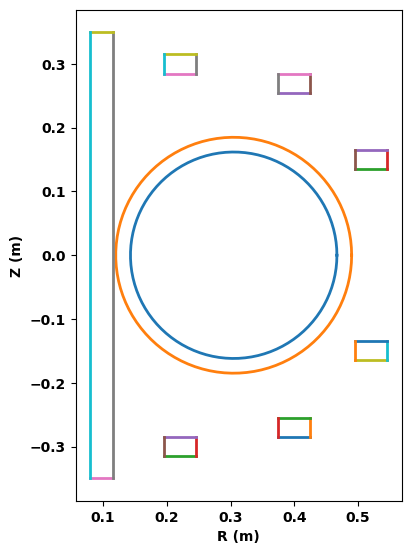

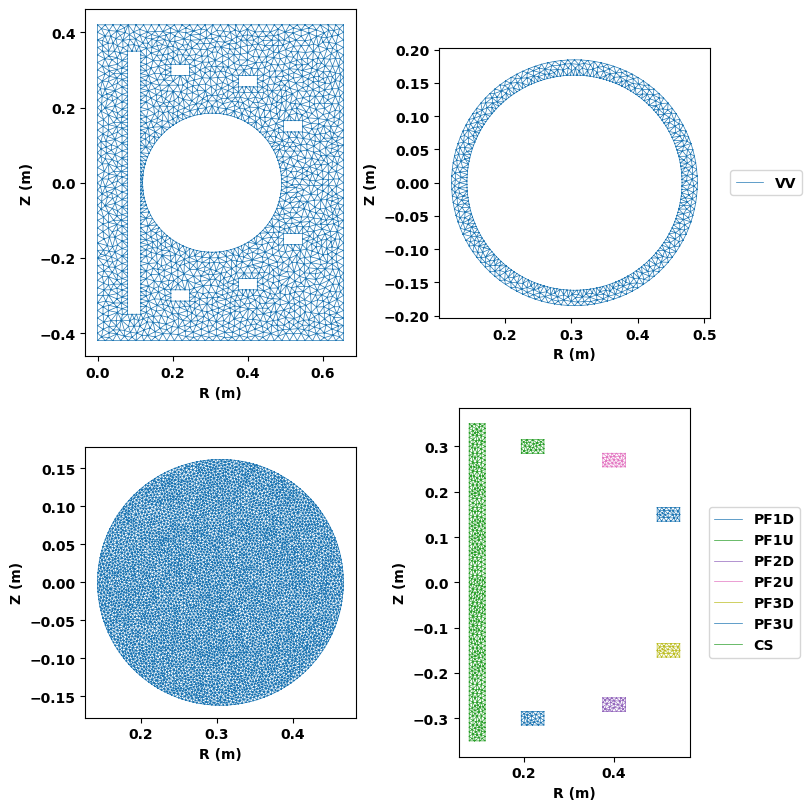

In [167]:
geom_name = 'ATOMCRAFT_geom1'
mesh_name = 'ATOMCRAFT_mesh1'
plasma_dx = 5e-3
coil_dx = 1e-2
vv_dx = 1e-2
vac_dx = 2e-2

with open(f'meshes/{geom_name}.yaml','r') as file:
    geom = yaml.safe_load(file)

# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air', vac_dx, 'boundary')
gs_mesh.define_region('plasma', plasma_dx, 'plasma')
gs_mesh.define_region('vv', vv_dx, 'conductor', eta=6.9E-7)

# Define each of the PF coils
for key, coil in geom['coils'].items():
    gs_mesh.define_region(key, coil_dx,'coil')

    # Define geometry
gs_mesh.add_annulus(geom['vv'][0], 'plasma', geom['vv'][1], 'vv', parent_name='air') # Define the shape of the VV
# Define the shape of the PF coils
for key, coil in geom['coils'].items():
    gs_mesh.add_rectangle(coil['r0'], coil['z0'], coil['w'], coil['h'], key, parent_name='air')

fig, ax = plt.subplots(1, 1, figsize=(4,6), constrained_layout=True)
gs_mesh.plot_topology(fig, ax)

mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

save_gs_mesh(mesh_pts, mesh_lc, mesh_reg, coil_dict, cond_dict, f'meshes/{mesh_name}.h5')

fig, ax = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)